### Manipulator Inverse Kinematics (IK)

In [1]:
import time
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from mujoco_parser import MuJoCoManipulatorParserClass
from util import rpy2r,r2w,trim_scale
print ("Done.")

Done.


### Parse manipulator

Creating offscreen glfw


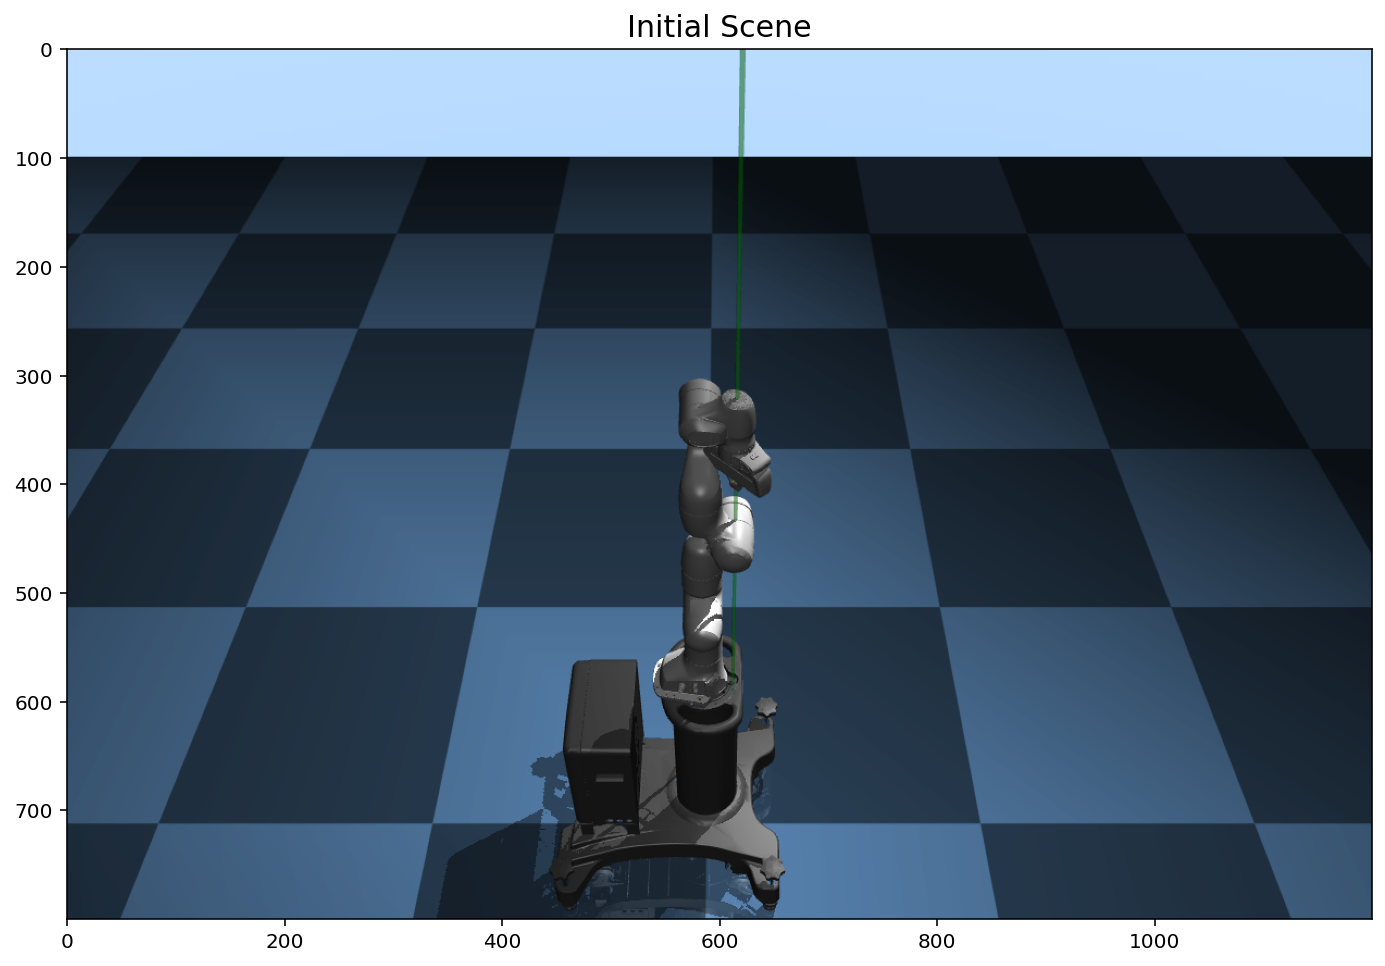

In [2]:
env = MuJoCoManipulatorParserClass(
    name='Panda',rel_path='../asset/panda/franka_panda.xml',ee_name='panda_eef',VERBOSE=False)
env.plot_scene(figsize=(12,8),render_w=1200,render_h=800,title_str='Initial Scene',title_fs=15)

### Loop

In [3]:
env.init_viewer(TERMINATE_GLFW=True,window_width=0.5,window_height=0.5)
env.set_max_tick(max_tick=1000)
env.reset() # reset env

q      = env.get_q_rev()
p_EE   = env.get_p_body(body_name='panda_eef')
R_EE   = env.get_R_body(body_name='panda_eef')
p_trgt = p_EE + np.array([0.5,0.0,-0.5])
R_trgt = R_EE

err_list = np.zeros(env.max_tick)
while env.IS_ALIVE():
    # IK
    p_EE = env.get_p_body(body_name='panda_eef')
    R_EE = env.get_R_body(body_name='panda_eef')
    J_p,J_R,J_full = env.get_J_body('panda_eef')
    p_err = (p_trgt-p_EE)
    R_err = np.linalg.solve(R_EE,R_trgt)
    w_err = R_EE @ r2w(R_err)
    J,err = J_full,np.concatenate((p_err,w_err))
    dq = np.linalg.solve(a=(J.T@J)+1e-6*np.eye(J.shape[1]),b=J.T@err)
    q  = q + trim_scale(x=dq,th=1.0*np.pi/180.0)
    
    # FK and render
    env.add_marker(pos=p_EE,radius=0.03,color=np.array([0,1,0,0.5]),label='EE tick:[%d]'%(env.tick))
    env.add_marker(pos=p_trgt,radius=0.03,color=np.array([1,0,0,0.5]),label='Target')
    env.forward_and_render(q_rev=q,RENDER_ALWAYS=True)
    env.print(print_every_sec=1.0,VERBOSE=1)
    
    # Append
    err_list[env.tick-1] = np.linalg.norm(err)

print ("Done.")

Creating window glfw
tick:[1/1001], sec_wall:[0.164]sec, sec_sim:[0.002]sec
tick:[501/1001], sec_wall:[1.145]sec, sec_sim:[1.002]sec
tick:[1001/1001], sec_wall:[2.172]sec, sec_sim:[2.002]sec
Done.


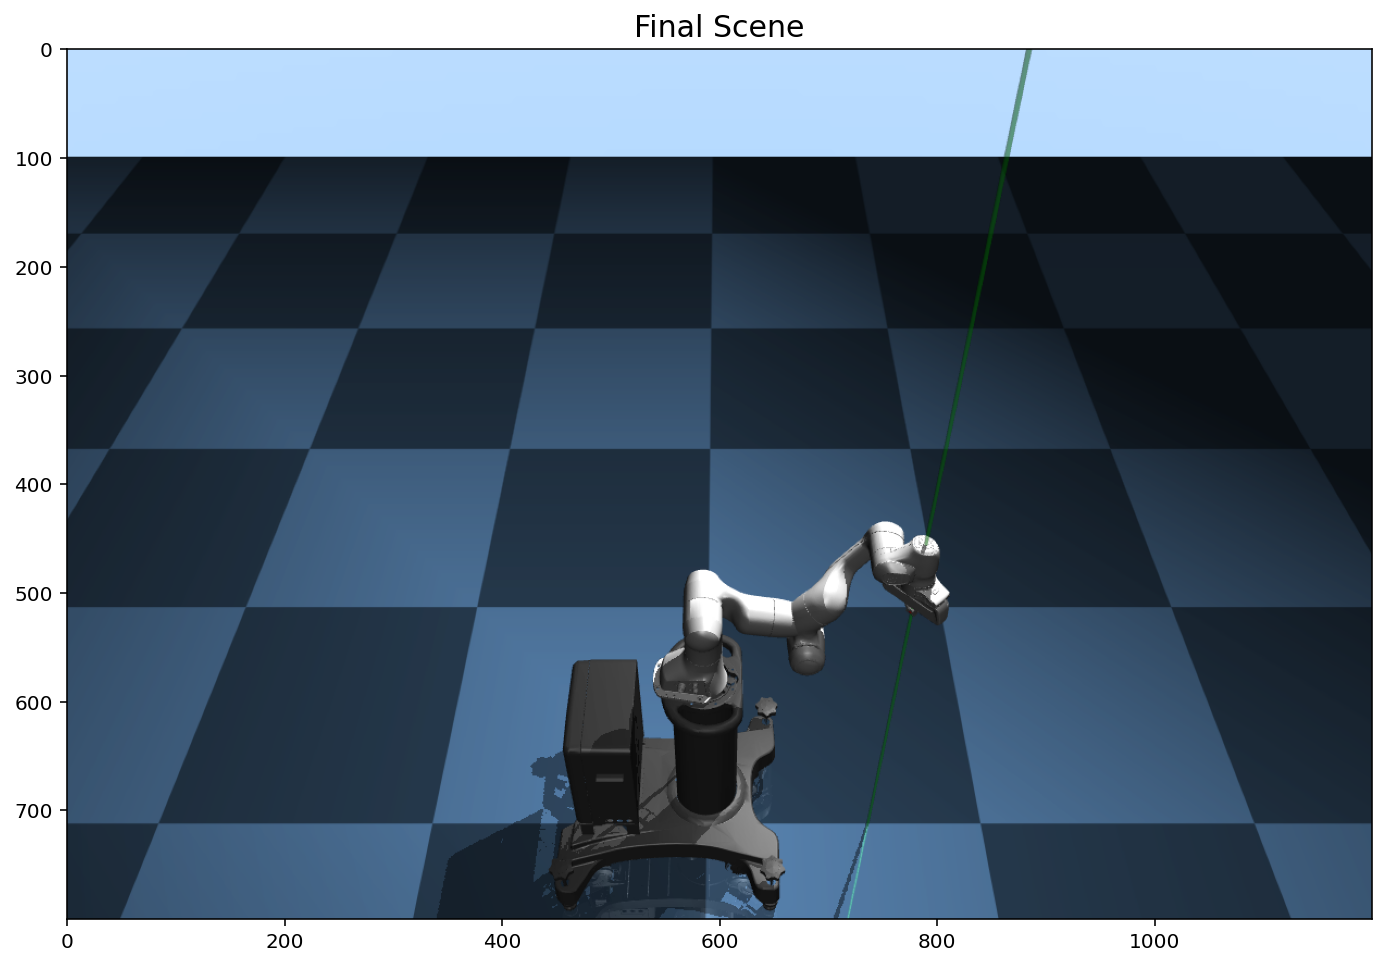

In [4]:
env.plot_scene(figsize=(12,8),render_w=1200,render_h=800,title_str='Final Scene',title_fs=15)

In [5]:
env.terminate_viewer() # terminate viewer

### Plot IK error

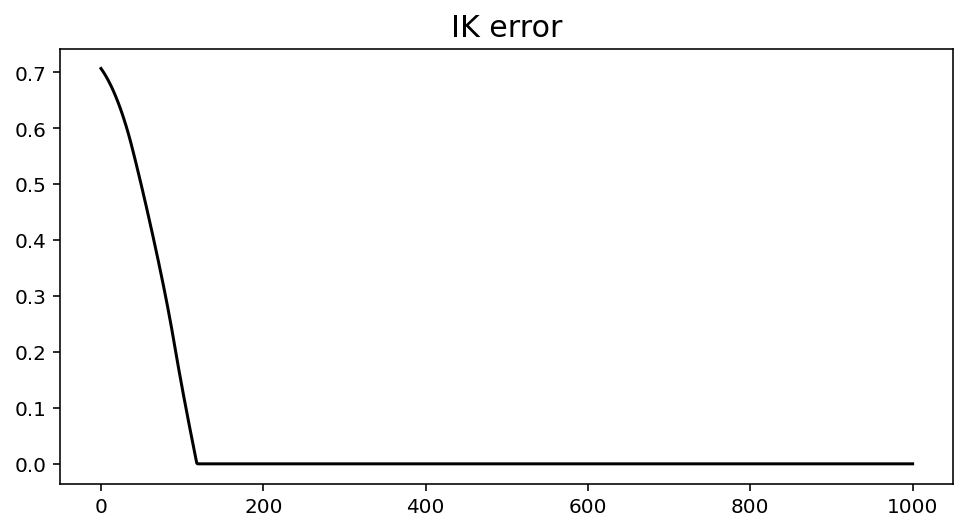

In [8]:
plt.figure(figsize=(8,4))
plt.plot(err_list,'-',color='k')
plt.title('IK error',fontsize=15)
plt.show()